# Feature Engineering
[Link do danych](https://www.kaggle.com/datasets/shubhamgoel27/dermnet)

About Dataset
Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

Content
The images are in JPEG format, consisting of 3 channels, i.e. RGB. The resolutions vary from image to image, and from category to category, but overall these are not extremely high resolution imagery.

The categories include acne, melanoma, Eczema, Seborrheic Keratoses, Tinea Ringworm, Bullous disease, Poison Ivy, Psoriasis, Vascular Tumors, etc.

Acknowledgements
The images are taken from the public portal Dermnet (http://www.dermnet.com/) which is the largest dermatology source online built for the purpose of providing online medical education.

## Loading libraries

In [4]:
import os
import cv2
import random
import imageio
import zipfile
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps
from PIL import ImageFilter
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
from sklearn.decomposition import PCA   
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from functools import partial
import SimpleITK as sitk
import scipy.ndimage as ndi
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.models import Model
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.spatial import distance
from scipy.spatial import distance
from skimage import io, measure, morphology, data, exposure
from skimage.feature import canny, graycomatrix, graycoprops
from skimage.color import rgb2gray, label2rgb
from skimage.filters import gaussian, threshold_otsu, try_all_threshold
from skimage.segmentation import slic
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Input
from tensorflow.keras.datasets import cifar10
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AgglomerativeClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter("ignore")

# pip list --format=freeze > requirements.txt

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## FE on sharpened/thresholded data

In [2]:
def is_image(file_path):
    try:
        Image.open(file_path).verify()
        return True
    except (IOError, SyntaxError) as e:
        return False
def load_images_from_folder(folder_path, filenames_to_skip):
    image_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image(file_path):
                try:
                    img = Image.open(file_path)
                    image_list.append(img)
                except (IOError, SyntaxError) as e:
                    print(f"Nie można otworzyć pliku {file_path}: {e}")
    return image_list
def remove_noise(image):
    return image.filter(ImageFilter.MedianFilter(size=3))
def sharpen_image(image):
    return image.filter(ImageFilter.SHARPEN)
def apply_otsu_threshold(image):
    grayscale_image = image.convert('L')
    np_image = np.array(grayscale_image)
    _, thresholded_image = cv2.threshold(np_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    result_image = Image.fromarray(thresholded_image)
    return result_image
def gaussian_blur(image, radius=2):
    return image.filter(ImageFilter.GaussianBlur(radius=radius))
def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()
def display_images_side_by_side(image1, image2):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title("Before modification")
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title("After modification")
    plt.show()

In [3]:
list_of_outliers = [
    # Acne and Rosacea Photos
    'Acne and Rosacea Photos//Forest-2.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-2.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-3.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-4.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-5.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-6.jpg',
    'Acne and Rosacea Photos//acne-primary-lesion-7.jpg',
    
    # Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
    
    # Atopic Dermatitis Photos
    
    # Bullous Disease Photos
    
    # Cellulitis Impetigo and other Bacterial Infections
    
    # Eczema Photos
    
    # Exanthems and Drug Eruptions
    
    # Hair Loss Photos Alopecia and other Hair Diseases
    
    # Herpes HPV and other STDs Photos
    'Herpes HPV and other STDs Photos//gonorrhea-13.jpg',
    'Herpes HPV and other STDs Photos//syphilis-17.jpg',
    
    # Light Diseases and Disorders of Pigmentation
    'Light Diseases and Disorders of Pigmentation//phototoxic-reactions-63.jpg',
    
    # Lupus and other Connective Tissue diseases
    
    # Melanoma Skin Cancer Nevi and Moles
    
    # Nail Fungus and other Nail Disease
    'Nail Fungus and other Nail Disease//exostosis-3.jpg',
    
    # Poison Ivy Photos and other Contact Dermatitis
    'Poison Ivy Photos and other Contact Dermatitis//patch-testing-8.jpg',
    'Poison Ivy Photos and other Contact Dermatitis//patch-testing-20.jpg',
    'Poison Ivy Photos and other Contact Dermatitis//patch-testing-15.jpg',
    
    # Psoriasis pictures Lichen Planus and related diseases
    'Psoriasis pictures Lichen Planus and related diseases//Psoriasis-treatment-6.jpg',
    
    # Scabies Lyme Disease and other Infestations and Bites
    'Scabies Lyme Disease and other Infestations and Bites//ants-2.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//ants-8.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//biting-insects-58.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//cat-bite-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//caterpillar-dermatitis-9.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//caterpillar-dermatitis-10.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//flea-bites-13.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//flea-bites-15.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-2.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-4.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//head-lice-6.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//jelly-fish-sting2.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pediculosis-body-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-34.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-36.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-42.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-44.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-45.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-46.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//pubic-lice-47.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//scabies-126.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//scabies-190.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-1.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-3.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-29.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-30.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-33.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//spider-bite-34.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-37.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-39.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-40.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-41.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-43.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-44.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-47.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-48.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-49.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-51.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-52.jpg',
    'Scabies Lyme Disease and other Infestations and Bites//tick-bite-59.jpg'
    # Seborrheic Keratoses and other Benign Tumors
    # Systemic Disease
    # Tinea Ringworm Candidiasis and other Fungal Infections
    # Urticaria Hives
    # Vascular Tumor
    # Vasculitis Photos
    # Warts Molluscum and other Viral Infections
]
folder_path = "C:\\Users\\HP\\ML\\Dermnet\\train"
images = load_images_from_folder(folder_path, list_of_outliers)

In [4]:
######## resized_images -> images as a numpy array
target_size = (128, 128)   
resized_images = []

for img_array in images:
    img = img_array.resize(target_size)
    img_array_resized = np.array(img) / 255.0  # Normalizacja do [0, 1]
    resized_images.append(img_array_resized)
images = []              ### Image format
for idx, img_array_resized in enumerate(resized_images):
    img = Image.fromarray((img_array_resized * 255).astype(np.uint8))
    images.append(img)

Based on the results and conclusions from exploratory data analysis (EDA), we will process the images in a couple of ways:

1. Noise removal
2. Applying image sharpening / thresholding

It doesn't make sense to apply multiple transformations or filters at once because the images become unreadable -> we will try to improve them slightly by applying one of the above methods at a time. Then, we will compare the results 

The presence of noise can lead to erroneous interpretations by clustering algorithms, resulting in incorrect groupings. Removing noise can improve the performance of algorithms. Noise removal can help achieve more clear and intuitive clustering results.

Image sharpening can enhance the essential features of objects in the image. By increasing the contrast between neighboring pixels, sharpening can help highlight object details.

The use of thresholding causes the loss of information about skin diseases but accurately captures the outlines of body parts. By applying a threshold, specific features of the image can be isolated, such as edges, lines, or areas of varying color saturation.

###### removing noise and sharpeing images

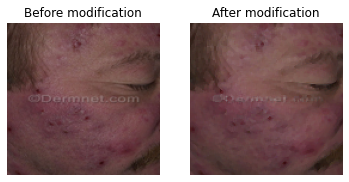

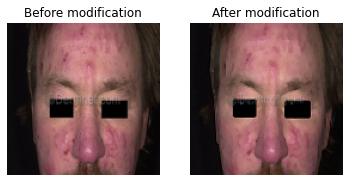

In [5]:
noise_sharp_img = []
for i in images:
    dn = remove_noise(i)
    sh = sharpen_image(dn)
    noise_sharp_img.append(sh)
display_images_side_by_side(images[21], noise_sharp_img[21])
display_images_side_by_side(images[20], noise_sharp_img[20])

###### removing noise and applying threshold

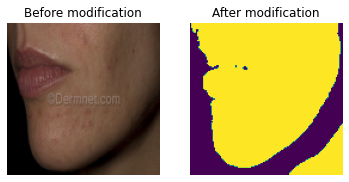

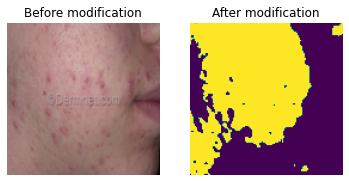

In [6]:
noise_thresh_img = []
for i in images:
    dn = remove_noise(i)
    thr = apply_otsu_threshold(dn)
    noise_thresh_img.append(thr)
display_images_side_by_side(images[600], noise_thresh_img[600])
display_images_side_by_side(images[0], noise_thresh_img[0])

In [ ]:
############################################################################ etap drugi -> ekstrakcja cech 

Now we will extract some features from the images. It is an important step before creating models. We'll use a pre-trained VGG16 model along with traditional feature extraction methods like color histogram, Histogram of Oriented Gradients (HOG), and Local Binary Pattern (LBP). 

functions and features description:

extract_color_histogram This function calculates the color histogram of the input image in the HSV (Hue, Saturation, Value) color space.

extract_hog_features: function to get features about HOG. HOG features represent the distribution of edge orientations in the image and are commonly used for object detection and recognition tasks.

extract_lbp_features: This function extracts Local Binary Pattern (LBP) features.. LBP features describe the local texture patterns in the image by comparing the intensity of each pixel with its neighboring pixels.

extract_deep_features: This function extracts deep features from the input image using the pre-trained VGG16 model. The image is preprocessed and passed through the VGG16 network, and the activations of the last convolutional layer are flattened to obtain a feature vector.

Finally, we will combine the features

In [7]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [8]:
def pil_to_cv2(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist
def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features, hog_image = hog(gray_image, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, multichannel=False)
    return hog_features
def extract_lbp_features(image, num_points=24, radius=8):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist
def extract_deep_features(image, model):
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image)
    features = features.flatten()
    return features
def combine_features(color_hist, hog_features, deep_features):
    combined_features = np.hstack([color_hist, hog_features, deep_features])
    return combined_features
def process_images(images):
    features_list = []
    for pil_image in images:
        cv2_image = pil_to_cv2(pil_image)
        color_hist = extract_color_histogram(cv2_image)
        hog_features = extract_hog_features(cv2_image)
        lbp_features = extract_lbp_features(cv2_image)
        deep_features = extract_deep_features(cv2_image, model)
        combined_features = combine_features(color_hist, hog_features, deep_features)
        features_list.append(deep_features)
    return np.vstack(features_list)

In [ ]:
sharp_feature = process_images(noise_sharp_img)

In [ ]:
thresh_feature = process_images(noise_thresh_img)

In [1]:
from sklearn.preprocessing import StandardScaler


C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Dim Reduction

In [12]:
def reduce_dimension(features):

    pca = PCA(n_components=2000)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    reduced_features = pca.fit_transform(scaled_features)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    return reduced_features

In [12]:
########################################### sharpened images

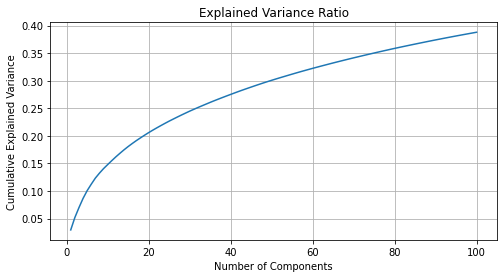

In [14]:
from sklearn.preprocessing import MinMaxScaler
features_sharp_pcaa = reduce_dimension(sharp_feature)

In [15]:
########################################### thresholded images

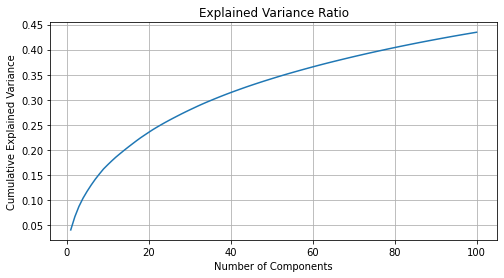

In [16]:
features_thre_pcaa = reduce_dimension(thresh_feature)

Now we have vectors with 100 features. In the modelling part we will create models and evaluate them

In [ ]:
########### uwagi walidacji: 
####### zamiast minmaxscaler uzyc standardscale -> zmieniono
####### zrobić ekstrakcję większej ilości cech - zmieniono
####### kod poniżej:

In [5]:
x = np.load("C:\\Users\\HP\\ML\\Dermnet\\yfi\\thresh_feature.npy")

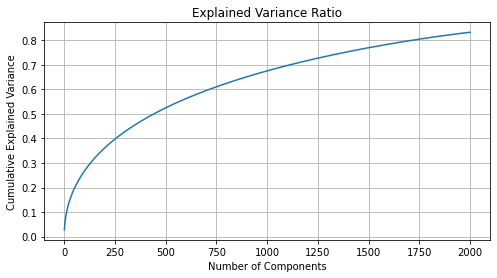

In [13]:
red_fe = reduce_dimension(x)

In [14]:
np.save("more_pca.npy", red_fe)

## FE: features from CNN
### Loading the dataset

In [26]:
# Define the path to the directory containing subdirectories with images
dataset_path = "C:\\Users\\HP\\ML\\Dermnet\\train"
files_per_directory = 10
img_size = 32

# Initialize an empty list to store the images
images = []

# Traverse the directory structure
for root, dirs, files in os.walk(dataset_path):
    
    limit = files_per_directory
    
    for file in files:
        if file.endswith('.jpg'):
            # Construct the full path to the image
            file_path = os.path.join(root, file)
            
            # Open the image
            img = Image.open(file_path)
            
            # Resize the image to 32x32 pixels
            img = img.resize((img_size, img_size))
            
            # Convert the image to a numpy array and normalize the pixel values
            img_array = np.array(img) / 255.0
            
            # Add the image array to the list
            images.append(img_array)
            
            # Adding a limit to images per directory
            limit -= 1
            if limit == 0:
                break

# Convert the list of images to a numpy array
images_array = np.array(images)

print(f"Shape of the images array: {images_array.shape}")

Shape of the images array: (230, 32, 32, 3)


### Building an autoencoder

In [27]:
# Define the autoencoder model
input_img = Input(shape=(img_size, img_size, 3))  # Adjust shape based on your images

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
train, test = train_test_split(images_array, test_size=0.7, random_state=42)
autoencoder.fit(train, test,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6942 - val_loss: 0.6871
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.6796 - val_loss: 0.7061
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.6893 - val_loss: 0.6870
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6767 - val_loss: 0.6853
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6786 - val_loss: 0.6852
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6794 - val_loss: 0.6849
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6780 - val_loss: 0.6857
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6755 - val_loss: 0.6865
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.6732 - val_loss: 0.6849
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.6713 - val_loss: 0.6838
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.6706 - val_loss: 0.6825
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.6696 - val_loss:

### Extracting features

In [28]:
# Create encoder model
encoder = Model(input_img, encoded)

# Extract features
features = encoder.predict(images_array)
features = features.reshape((features.shape[0], -1))  # Flatten the features for clustering
features_original = features.copy()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### Dimensionality reduction

In [29]:
def reduce_dimensions_pca(pca_components, features, do_plot=False):

    features = PCA(n_components=pca_components).fit_transform(features)

    pca = PCA().fit(features)

    if do_plot:
        plt.figure(figsize=(8,  4))
        plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
    
    return features

#features = reduce_dimensions_pca(100, features, True)
# features = features_original

### Evaluating the Clusters

In [30]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def count_wcss_scores(X, k, model):
    #  WCSS = within-cluster sum of squares
    kmeans = model(n_clusters=k, random_state=0)
    kmeans.fit(X)
    return kmeans.score(X) * -1 # score returns -WCSS

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def create_data_frame(max_parameter, features):

    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Example data to add row by row
    algorithms = {
        'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
        'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
        'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
        'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
        'Kmeans': KMeans,
        'KMedoids': KMedoids
    }
    metrics = {
        'min dist between clusters': min_interclust_dist,
        'mean dist in clust': mean_inclust_dist,
        'std dev dist in clust': std_dev_of_inclust_dist,
        'mean dist to clust center': mean_dist_to_center,
        'silhouette': silhouette_score,
    }

    index = 0
    # Add rows to the DataFrame in a for loop
    for i, algorithm in enumerate(algorithms):
        print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
        for cluster_num in range(2, max_parameter+1):
            print(f'{cluster_num}-', end='')
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
    #         df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
            index += 1
        print(']')
        
    return df
   
df = create_data_frame(5, features)
df.head()

Agglomerative ward linkage       [-2-3-4-5-]
Agglomerative complete linkage   [-2-3-4-5-]
Agglomerative average linkage    [-2-3-4-5-]
Agglomerative single linkage     [-2-3-4-5-]
Kmeans                           [-2-3-4-5-]
KMedoids                         [-2-3-4-5-]


Algorithm Parameters  Feature_len  \
0      Agglomerative ward linkage          2       8192.0   
1      Agglomerative ward linkage          3       8192.0   
2      Agglomerative ward linkage          4       8192.0   
3      Agglomerative ward linkage          5       8192.0   
4  Agglomerative complete linkage          2       8192.0   

   min dist between clusters  mean dist in clust  std dev dist in clust  \
0                   0.735770            2.313116               0.042793   
1                   0.735770            2.353060               0.509973   
2                   0.713415            2.131533               0.581330   
3                   0.713415            2.119133               0.512929   
4                   1.659742            2.620955               0.221026   

   mean dist to clust center  silhouette  
0                   1.603670    0.140739  
1                   1.634523    0.143458  
2                   1.477097    0.074813  
3                   1.465982    0.083277  
4                   1.781645    0.282689

In [31]:
def plot_df(df):
    # List of metrics to plot
    metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette',
    #     'WCSS'
    ]

    # Set up the subplot grid (3 rows, 2 columns)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Iterate over metrics and create a plot for each
    for i, metric in enumerate(metrics_vals):
        sns.lineplot(data=df, x='Parameters', y=metric, hue='Algorithm', marker='o', ax=axes[i])
        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Parameters')
        axes[i].legend(title='Algorithm')
        axes[i].grid(True)
    fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
#plot_df(df)
def plot_df(df):
    # Lista metryk do wykreślenia
    metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette',
    ]

    # Iteracja przez metryki i tworzenie wykresu dla każdej z nich
    for i, metric in enumerate(metrics_vals):
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x='Parameters', y=metric, hue='Algorithm', marker='o')
        plt.title(f'{metric}')
        plt.ylabel(metric)
        plt.xlabel('Parameters')
        plt.legend(title='Algorithm')
        plt.grid(True)
        
        # Zapisz wykres do pliku PNG z przezroczystym tłem
        plt.savefig(f'{metric}.png', transparent=True)
        plt.close()

### Applying K-means Clustering

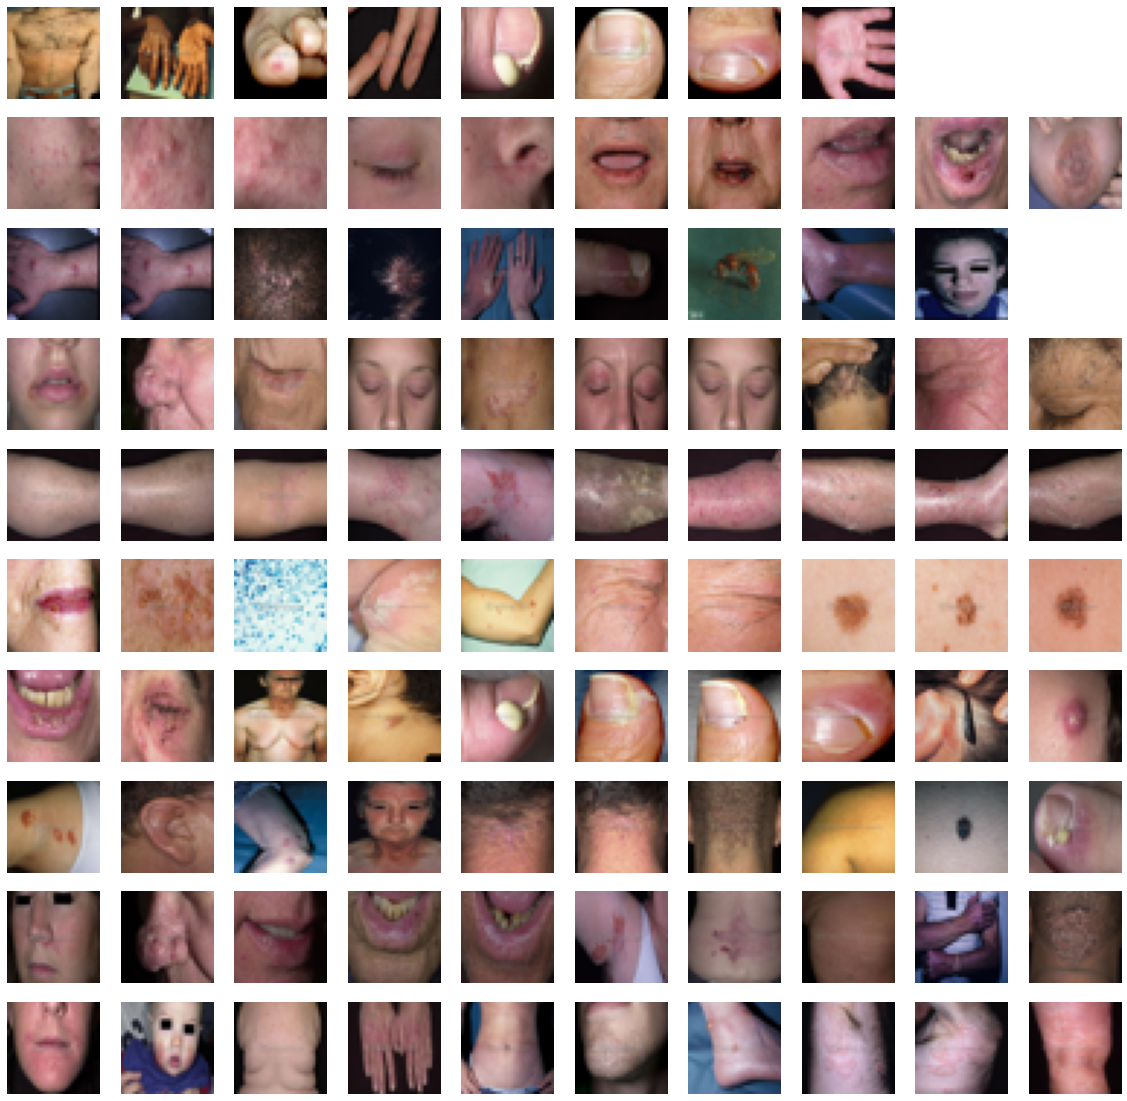

In [32]:
# Define the number of clusters
num_clusters = 10  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

def plot_clusters(images, labels, num_clusters):
    plt.figure(figsize=(20, 20))
    for cluster in range(num_clusters):
        cluster_images = images[labels == cluster]
        for i in range(min(len(cluster_images), 10)):
            plt.subplot(num_clusters, 10, cluster * 10 + i + 1)
            plt.imshow(cluster_images[i])
            plt.axis('off')
    plt.show()

plot_clusters(images_array, clusters, num_clusters)

## Normalizing brightness and adding zero-padding

In [34]:
def add_padding_to_make_square(img):
    """
    Add padding to an image to make it square.
    """
    width, height = img.size
    if width == height:
        return img
    else:
        max_side = max(width, height)
        new_img = ImageOps.expand(img, (
            (max_side - width) // 2, 
            (max_side - height) // 2, 
            (max_side - width + 1) // 2, 
            (max_side - height + 1) // 2
        ), fill=(0, 0, 0))
        return new_img

def adjust_brightness(img, target_brightness):
    """
    Adjust the brightness of an image to match the target brightness.
    """
    grayscale_img = img.convert('L')
    img_array = np.array(grayscale_img)
    
    current_brightness = np.mean(img_array)
    brightness_factor = target_brightness / current_brightness
    
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array * brightness_factor
    
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(img_array)

def normalize_images_brightness(images, target_brightness=None):
    """
    Normalize the brightness of all images to match the target brightness.
    """
    if target_brightness is None:
        total_brightness = 0
        for img in images:
            grayscale_img = img.convert('L')
            img_array = np.array(grayscale_img)
            total_brightness += np.mean(img_array)
        target_brightness = total_brightness / len(images)
    
    normalized_images = [adjust_brightness(img, target_brightness) for img in images]
    
    return normalized_images

# Load images from directory and pad them to be square, then resize to 32x32
data_dir = "C:\\Users\\HP\\ML\\Dermnet\\train"
img_size = 32
images = []
for root, dirs, files in os.walk(data_dir):
    for file in files[:500]:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img = add_padding_to_make_square(img)
            img = img.resize((img_size, img_size))
            images.append(img)

# Normalize the brightness of all images
normalized_images = normalize_images_brightness(images)

# Convert normalized images to numpy array
images_array = np.array([np.array(img) / 255.0 for img in normalized_images])

print(f"Shape of the images array: {images_array.shape}")

Shape of the images array: (9957, 32, 32, 3)


In [35]:
# Define the autoencoder model
input_img = Input(shape=(img_size, img_size, 3))  # Adjust shape based on your images

# Feature layers to plot later
layers = []

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
layers.append(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
layers.append(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
layers.append(encoded)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
layers.append(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
layers.append(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
layers.append(decoded)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
train, test = train_test_split(images_array, test_size=0.7, random_state=42)
autoencoder.fit(train, test,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

# Create encoder model
encoder = Model(input_img, encoded)

# Extract features
features = encoder.predict(images_array)
features = features.reshape((features.shape[0], -1))  # Flatten the features for clustering
features_original = features.copy()

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - loss: 0.6700 - val_loss: 0.6029
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 0.5814 - val_loss: 0.5487
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 0.5398 - val_loss: 0.5278
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.5251 - val_loss: 0.5235
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.5228 - val_loss: 0.5195
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.5180 - val_loss: 0.5190
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.5185 - val_loss: 0.5178
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.5172 - val_loss: 0.5175
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - loss: 0.5161 - val_loss: 0.5168
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.5172 - val_loss: 0.5162
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.5152 - val_loss: 0.5158
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


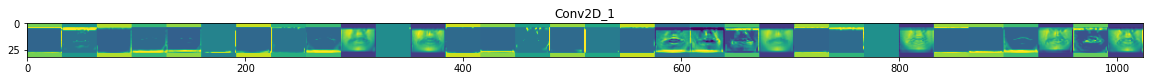

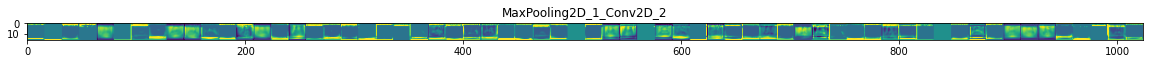

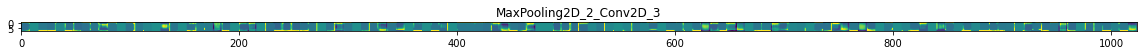

In [36]:
# Create intermediate layer model
layer_outputs = layers
feature_model = Model(inputs=autoencoder.input, outputs=layer_outputs)

# Get the feature maps
sample_image = images_array[7]  # Use the first image as a sample
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension
feature_maps = feature_model.predict(sample_image)

# Plot the feature maps
def plot_feature_maps(feature_maps, layer_names):
    num_layers = len(feature_maps)
    for layer_idx, feature_map in enumerate(feature_maps):
        num_filters = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(layer_names[layer_idx])
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
def plot_all_images(images, columns=10):
    """
    Plot all images in the given array.

    Parameters:
    - images: Array of images (numpy arrays).
    - title: Title for the plot (default: "Images").
    - columns: Number of columns in the plot grid (default: 5).
    """
    num_images = len(images)
    rows = (num_images // columns) + 1
    
    plt.figure(figsize=(15, num_images/10))
    
    for i in range(num_images):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.show()

layer_names = ['Conv2D_1', 'MaxPooling2D_1_Conv2D_2', 'MaxPooling2D_2_Conv2D_3',
               'Conv2D_1', 'UpSampling2D_1_Conv2D_2', 'UpSampling2D_2_Conv2D_3']
plot_feature_maps(feature_maps[:-3], layer_names[:-3])

### Clustering
#### Dimensionality reduction with PCA

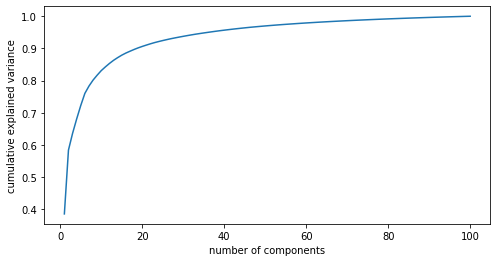

In [37]:
features = reduce_dimensions_pca(100, features, True)
# features = features_original

#### Evaluating clusters

In [39]:
df = create_data_frame(20, features)

Agglomerative ward linkage       [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-

KeyboardInterrupt: 

In [16]:
pip install --upgrade pandas
#pip install --upgrade matplotlib seaborn

SyntaxError: invalid syntax (2975873775.py, line 1)

In [ ]:
plot_df(df)

#### Showcasing clustering results
##### Agglomerative ward linkage ward

In [24]:
# Define the number of clusters
num_clusters = 20

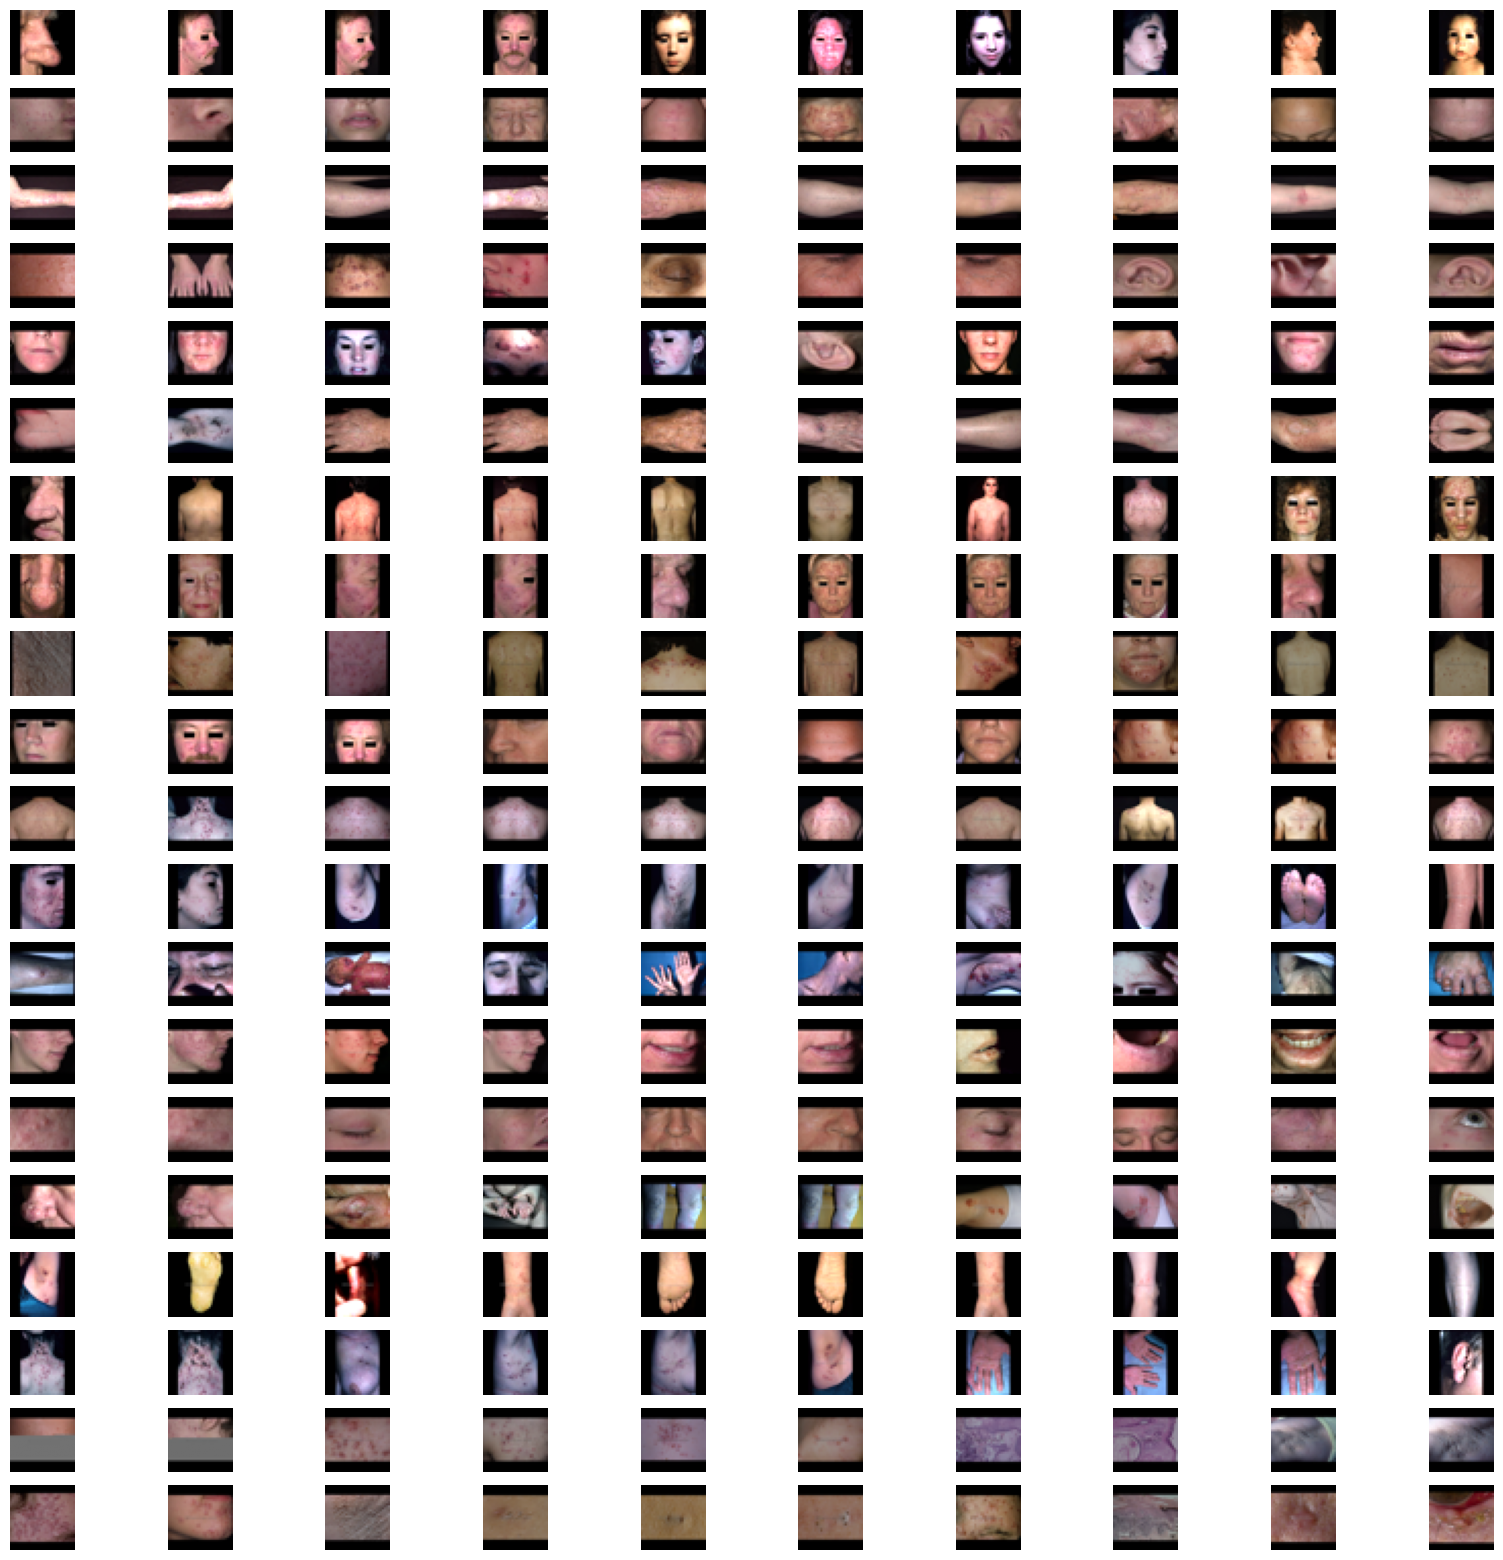

In [25]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### Agglomerative ward linkage complete

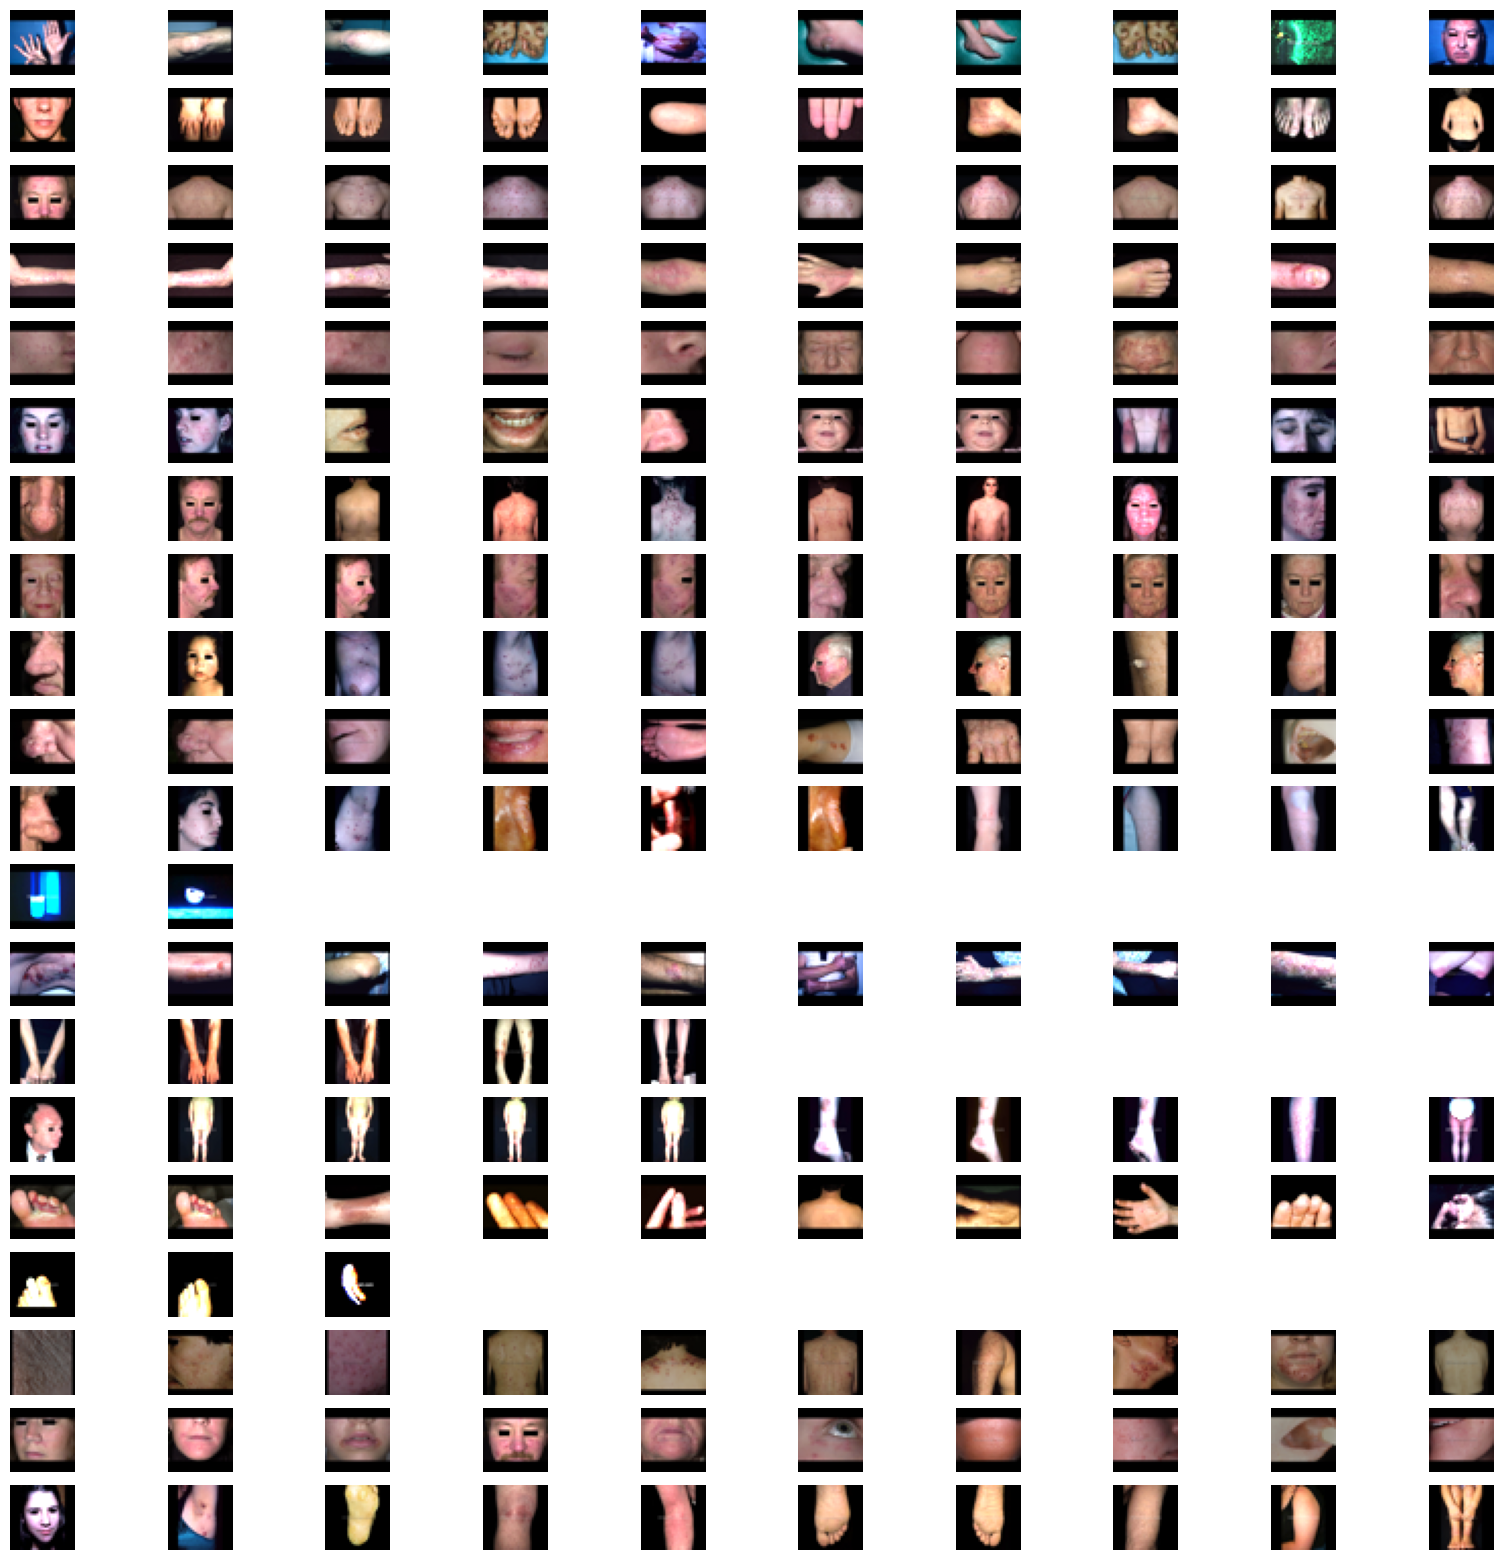

In [26]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='complete').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### Agglomerative ward linkage average

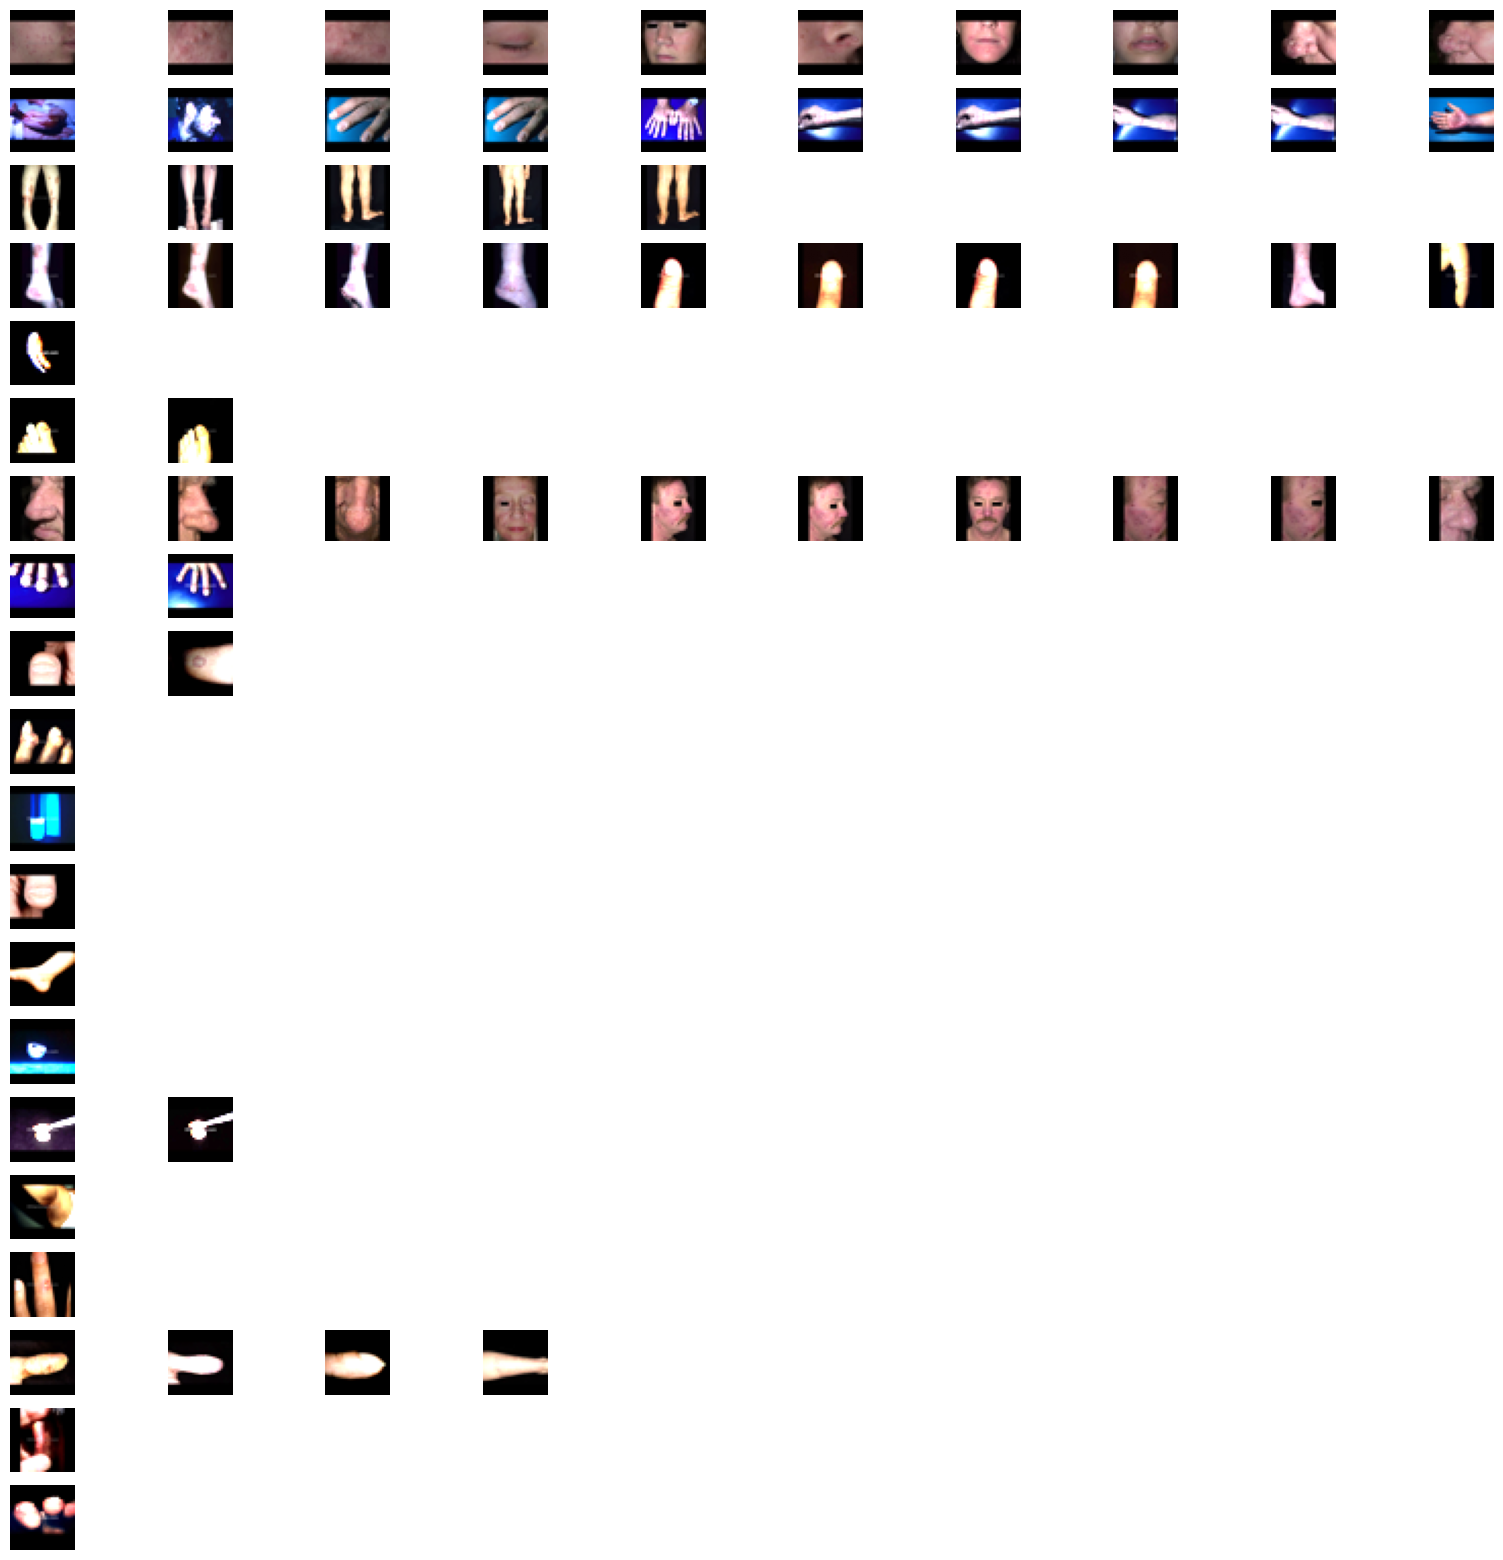

In [27]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='average').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### Agglomerative ward linkage single

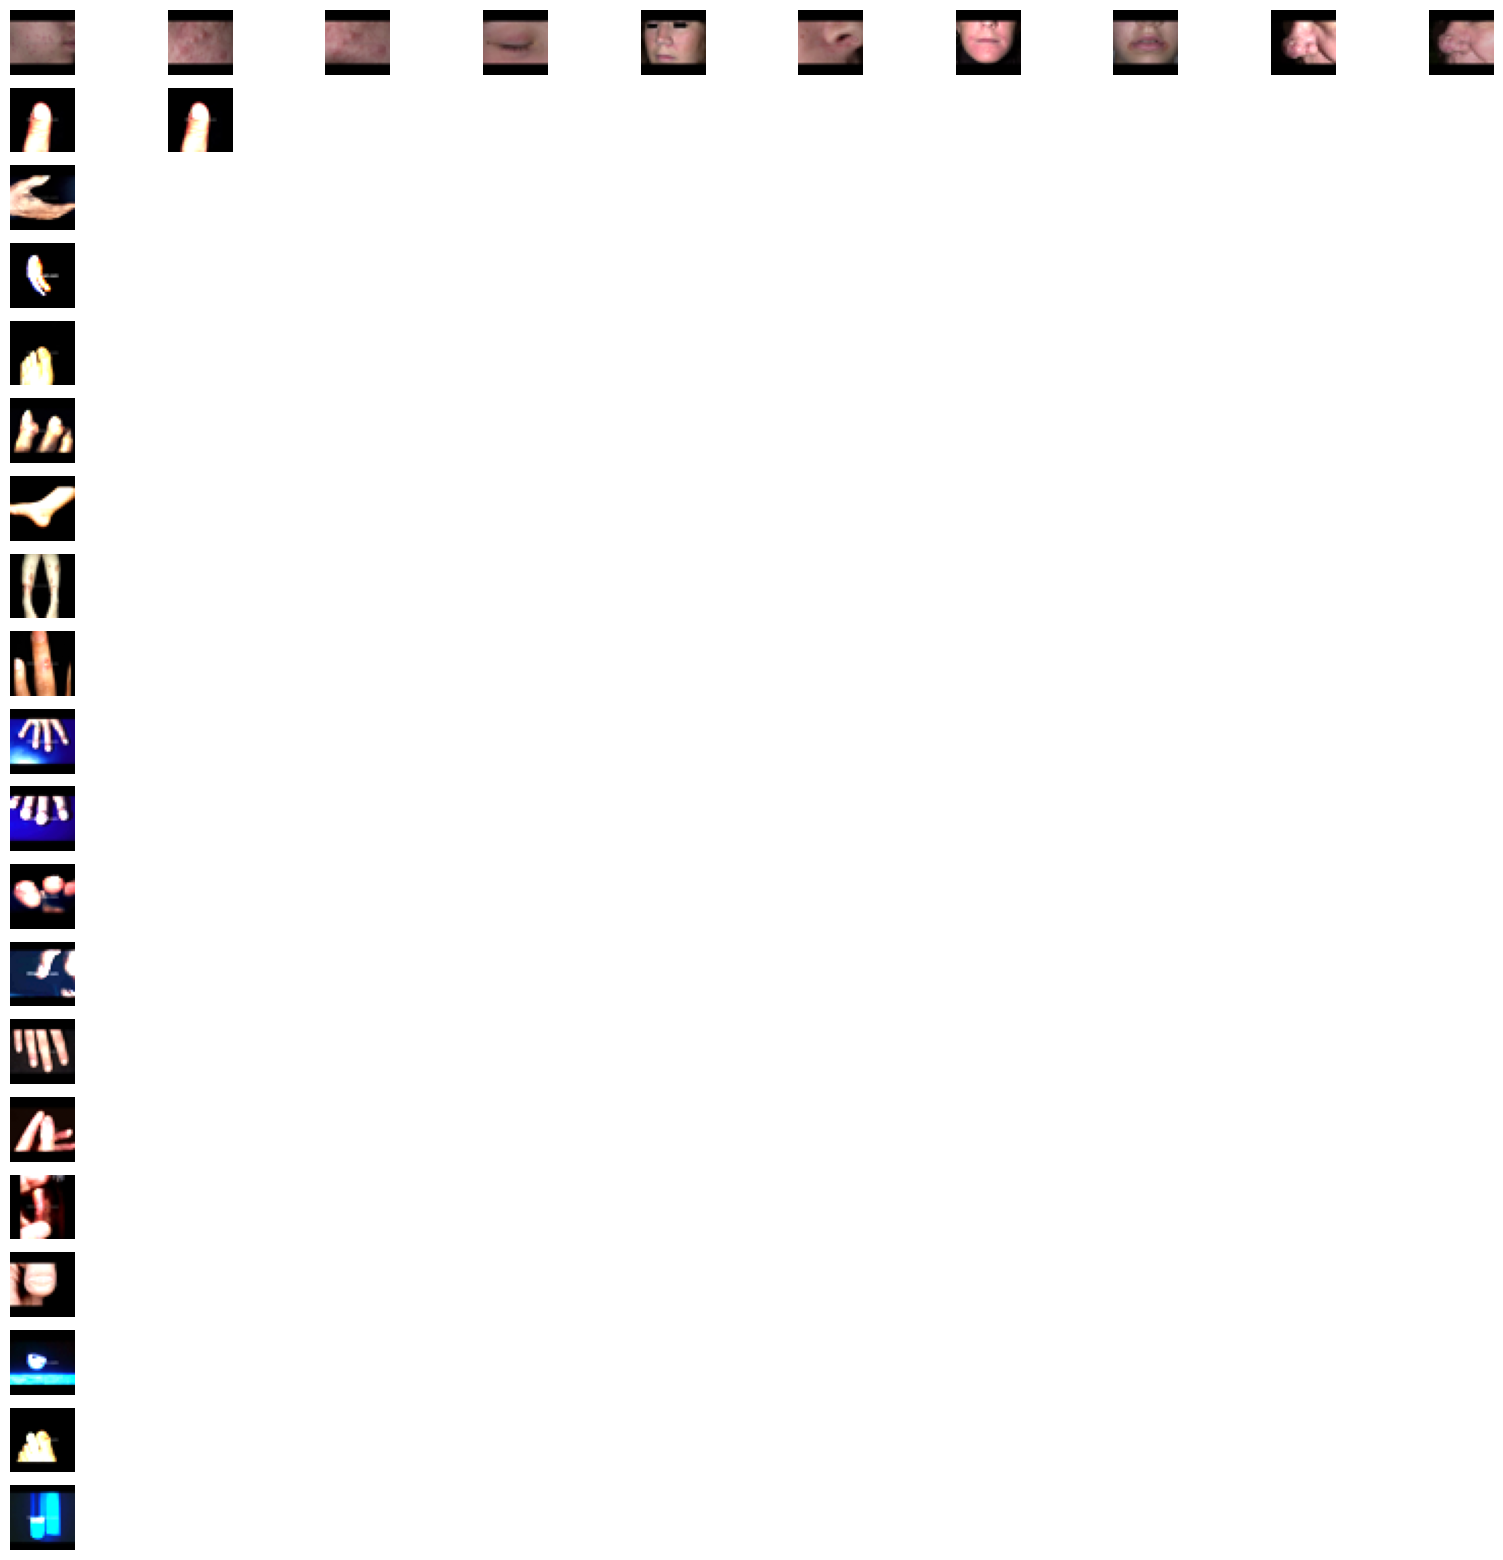

In [28]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='single').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### KMeans

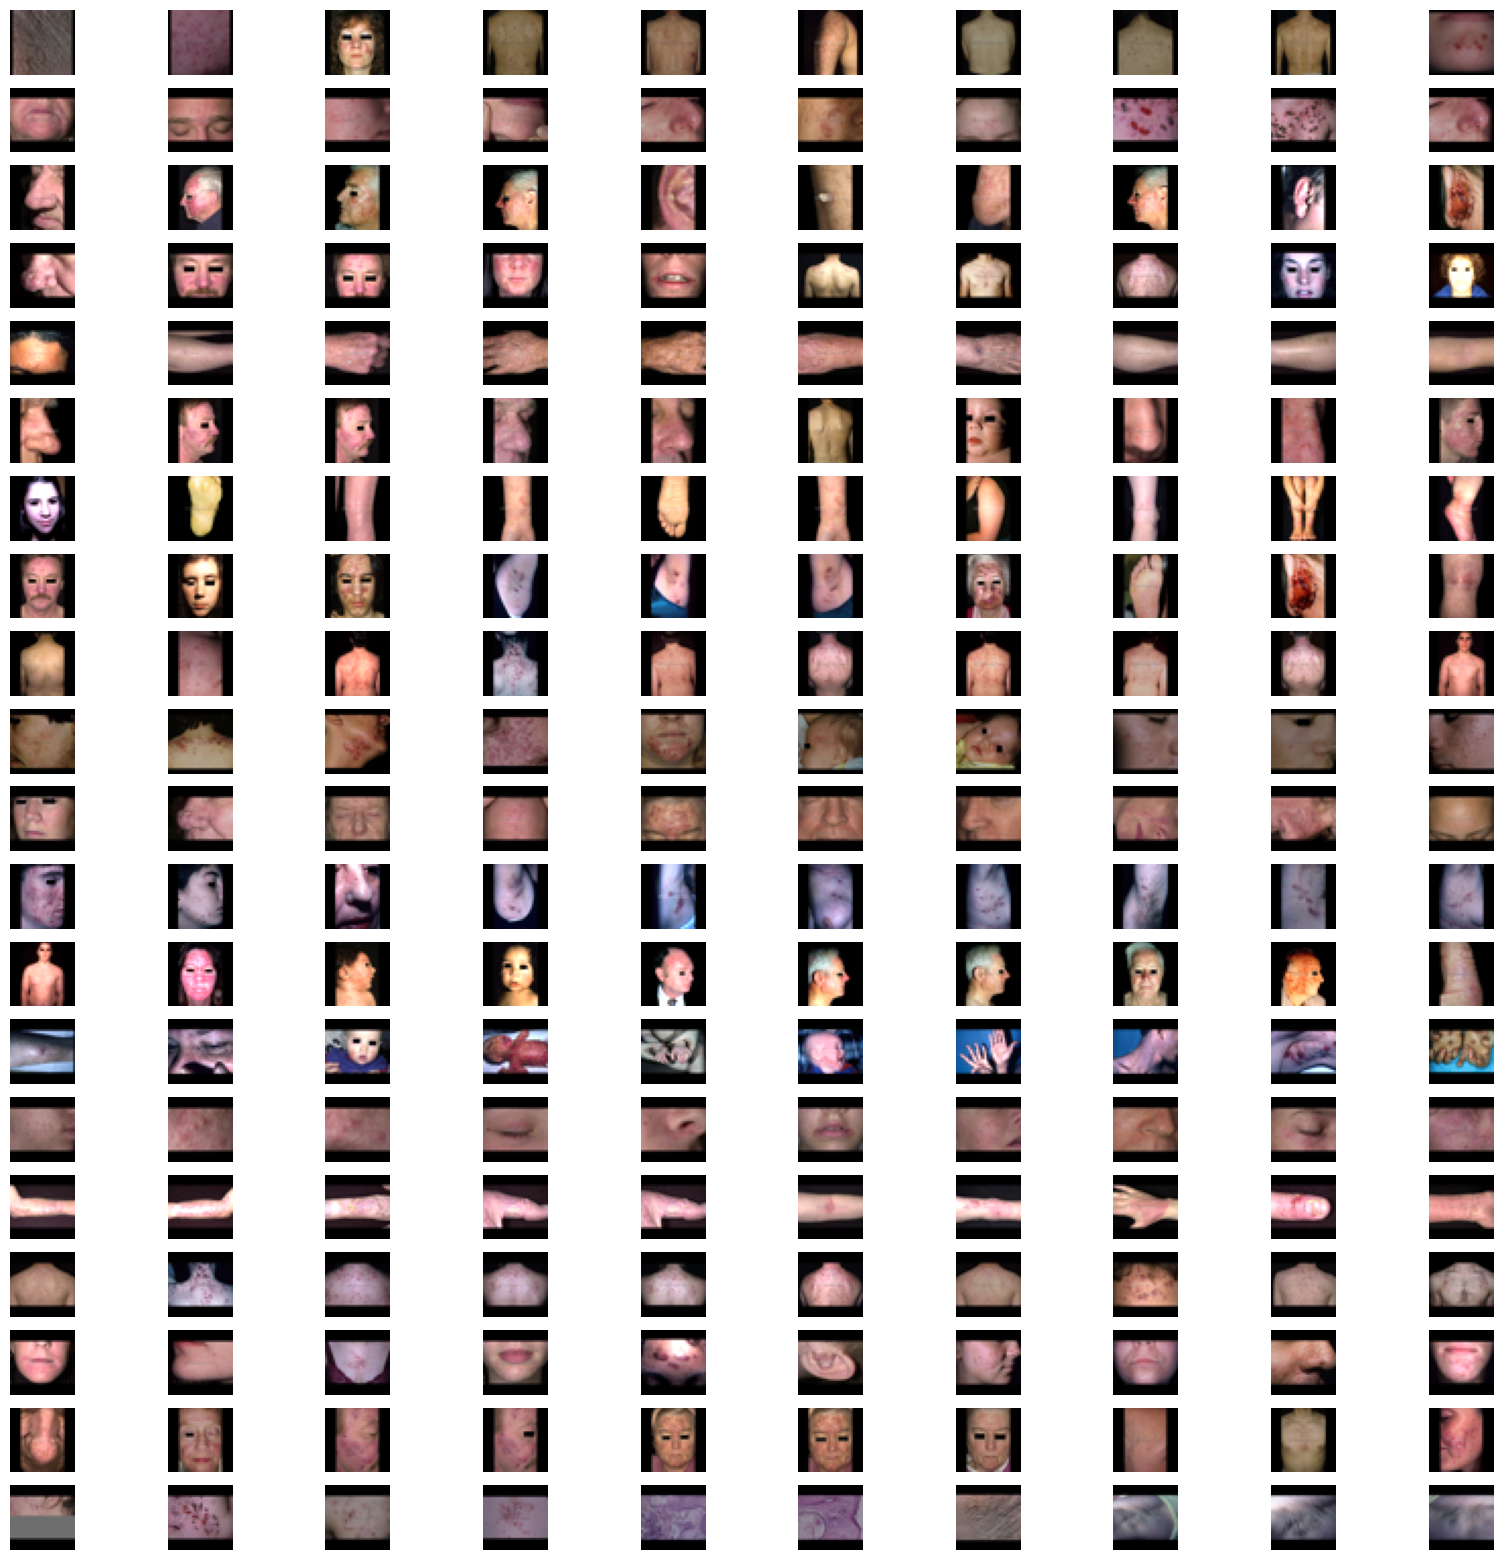

In [29]:
clusters = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### KMedoids

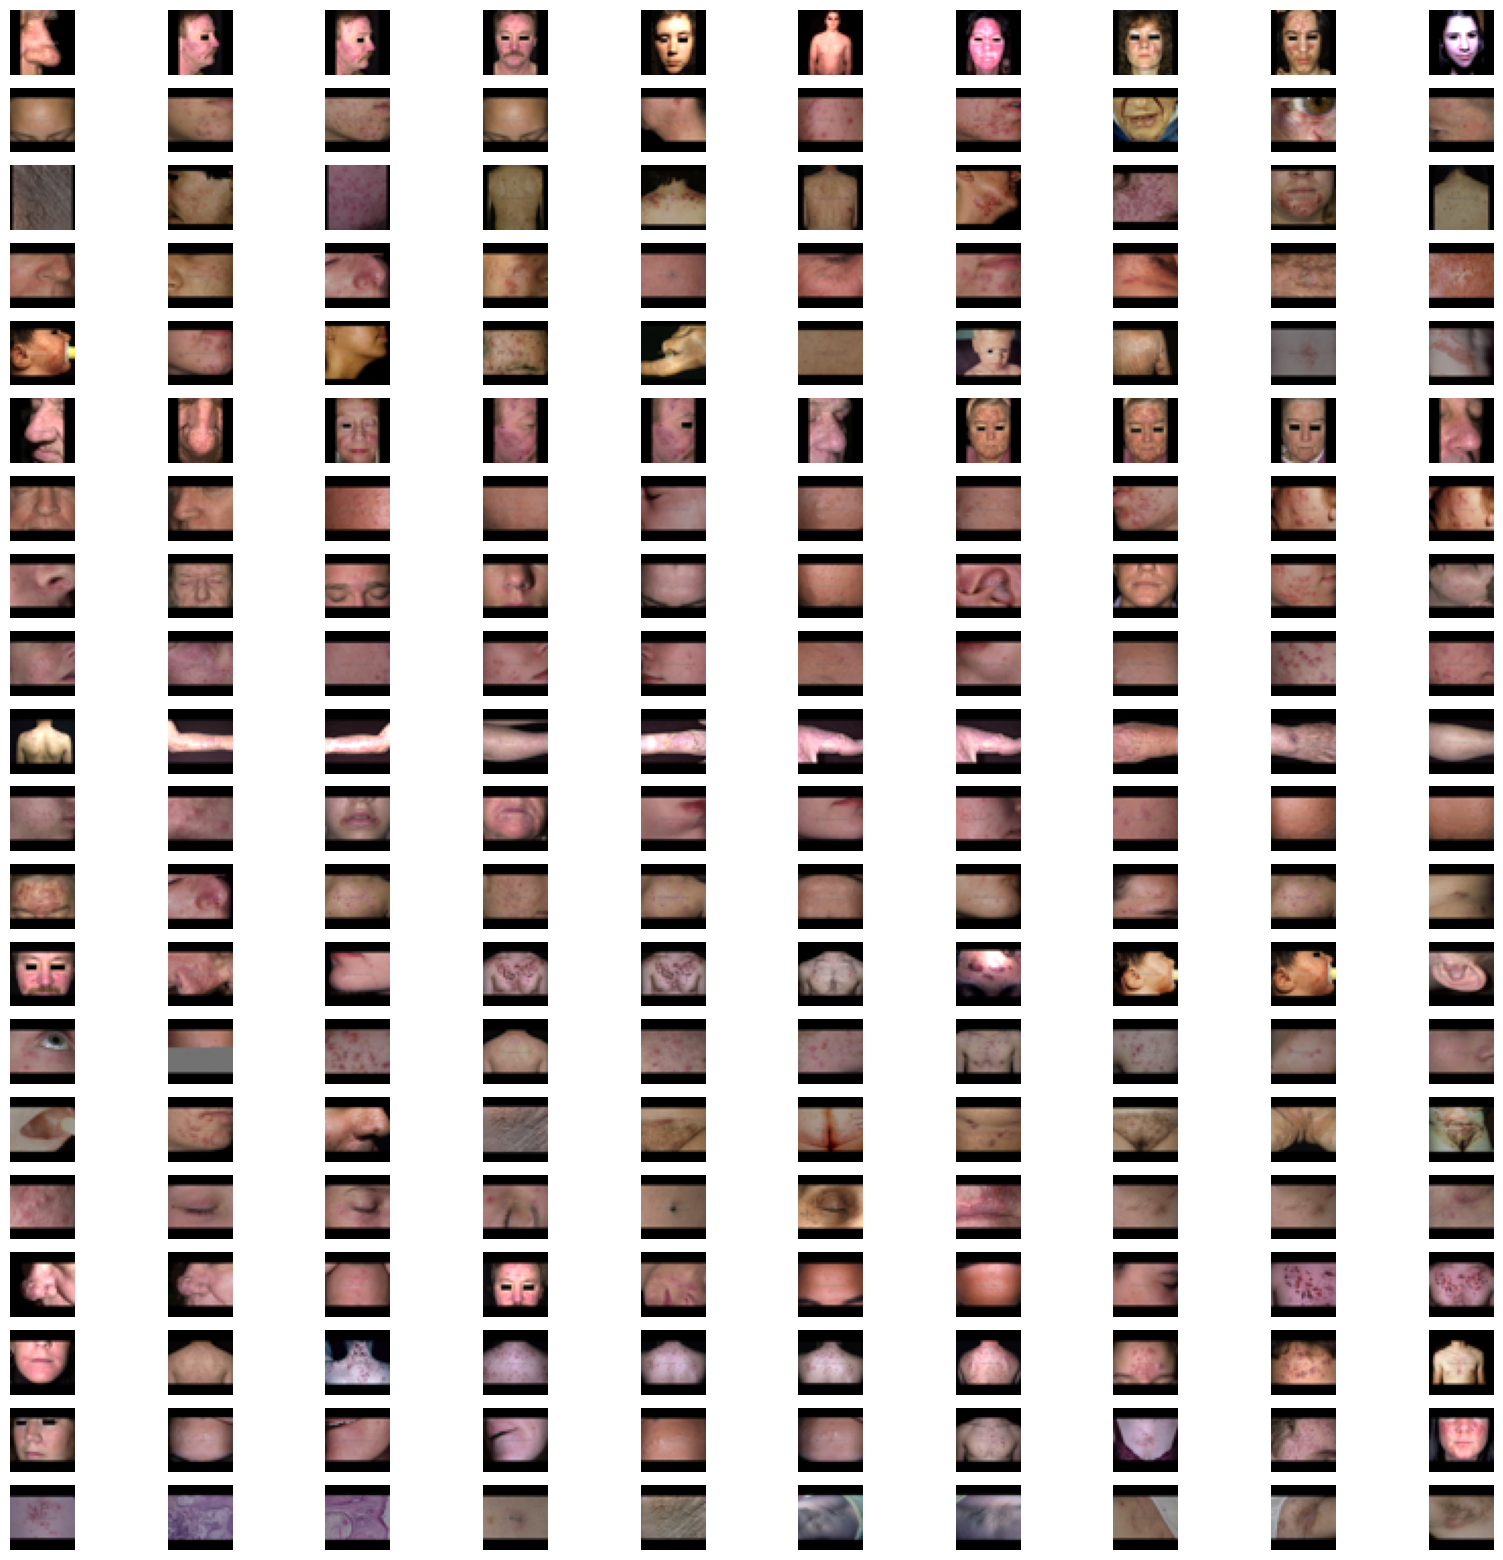

In [30]:
clusters = KMedoids(n_clusters=num_clusters, random_state=42).fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

###  Further  analysis of Kmeans

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

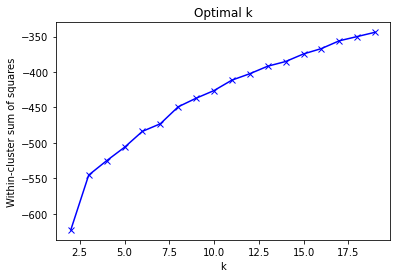

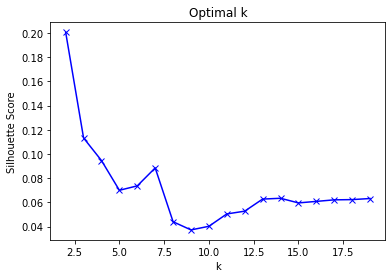

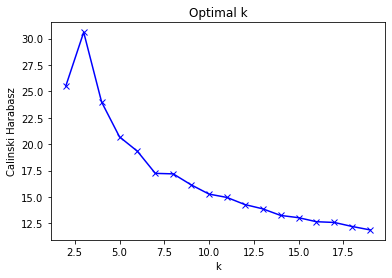

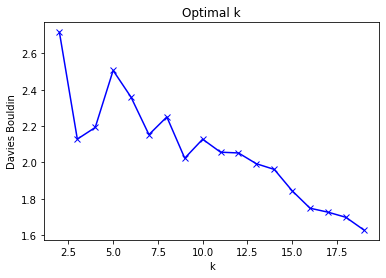

In [13]:
def metrics_plots(max_k, X):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))
        print(f'{k} ', end='')

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

features = reduce_dimensions_pca(200, features_original, False)
metrics_plots(20, features)

In [14]:
# Initialize an empty DataFrame
df = pd.DataFrame()
max_parameter = 20

# Example data to add row by row
algorithms = {
    'Kmeans': KMeans
}
metrics = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

index = 0
# Add rows to the DataFrame in a for loop
for p in range(200, 10, -10):
    features = reduce_dimensions_pca(p, features_original, False)
    print('{0: <3}'.format(f'{p}')+' ', end='')
    for i, algorithm in enumerate(algorithms):
        for cluster_num in range(2, max_parameter+1):
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
            df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
            index += 1
# features = features_original
# for i, algorithm in enumerate(algorithms):
#         print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
#         for cluster_num in range(2, max_parameter+1):
#             print(f'{cluster_num}-', end='')
#             df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
#             df.loc[index, 'Feature_len'] = len(features[0])
#             df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
#             model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
#             df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
#             index += 1
#         print(']')
   
df

200 190 180 170 160 150 140 130 120 110 100 90  80  70  60  50  40  30  20  

Algorithm Parameters  Feature_len  min dist between clusters  \
0      Kmeans          2        200.0                   0.586128   
1      Kmeans          3        200.0                   0.547348   
2      Kmeans          4        200.0                   0.547348   
3      Kmeans          5        200.0                   0.586128   
4      Kmeans          6        200.0                   0.547348   
..        ...        ...          ...                        ...   
356    Kmeans         16         20.0                   0.169420   
357    Kmeans         17         20.0                   0.250910   
358    Kmeans         18         20.0                   0.366667   
359    Kmeans         19         20.0                   0.438067   
360    Kmeans         20         20.0                   0.459781   

     mean dist in clust  std dev dist in clust  mean dist to clust center  \
0              2.183625               0.243554                   1.603398   
1              2.282105               0.599312                   1.575991   
2              2.461571               0.514758                   1.482118   
3              2.183018               0.790985                   1.173160   
4              2.048854               0.430820                   1.488779   
..                  ...                    ...                        ...   
356            1.742979                    NaN                   0.953704   
357                 NaN                    NaN                   0.955984   
358                 NaN                    NaN                   0.916325   
359                 NaN                    NaN                   0.953908   
360                 NaN                    NaN                   0.795330   

     silhouette        WCSS  
0      0.116315  606.009766  
1      0.108386  587.290161  
2      0.084700  528.864990  
3      0.083245  500.453735  
4      0.098660  494.320099  
..          ...         ...  
356    0.084539  257.800995  
357    0.097486  252.224838  
358    0.084894  244.890869  
359    0.106904  237.510208  
360    0.089285  234.062302  

[361 rows x 9 columns]

In [15]:
df_tmp = df[df['Feature_len']<1000]

metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette',
        'WCSS'
]

for i, metric in enumerate(metrics_vals):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_tmp, x='Parameters', y=metric, hue='Feature_len', marker='o')
    plt.title(f'{metric}')
    plt.ylabel(metric)
    plt.xlabel('Parameters')
    plt.legend(title='Feature_len')
    plt.grid(True)
    
    # Zapisz wykres do pliku PNG z przezroczystym tłem
    plt.savefig(f'{metric}.png', transparent=True)
    plt.close()


### Kmeans vs KMedoids for 200 feature vector

In [151]:
# Initialize an empty DataFrame
df = pd.DataFrame()
max_parameter = 20

# Example data to add row by row
algorithms = {
    'Kmeans': KMeans,
    'KMedoids': KMedoids
}
metrics = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

index = 0
features = reduce_dimensions_pca(200, features_original, False)
for i, algorithm in enumerate(algorithms):
        print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
        for cluster_num in range(2, max_parameter+1):
            print(f'{cluster_num}-', end='')
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
            index += 1
        print(']')
   
df

Kmeans                           [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
KMedoids                         [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]


Algorithm  Parameters  Feature_len  min dist between clusters  \
0     Kmeans         2.0        200.0                   0.859890   
1     Kmeans         3.0        200.0                   0.967882   
2     Kmeans         4.0        200.0                   0.793955   
3     Kmeans         5.0        200.0                   0.770811   
4     Kmeans         6.0        200.0                   0.864157   
5     Kmeans         7.0        200.0                   1.106465   
6     Kmeans         8.0        200.0                   1.047859   
7     Kmeans         9.0        200.0                   0.599130   
8     Kmeans        10.0        200.0                   0.564175   
9     Kmeans        11.0        200.0                   0.324529   
10    Kmeans        12.0        200.0                   0.564175   
11    Kmeans        13.0        200.0                   0.324529   
12    Kmeans        14.0        200.0                   0.431177   
13    Kmeans        15.0        200.0                   0.318862   
14    Kmeans        16.0        200.0                   0.431177   
15    Kmeans        17.0        200.0                   0.431177   
16    Kmeans        18.0        200.0                   0.255706   
17    Kmeans        19.0        200.0                   0.405513   
18    Kmeans        20.0        200.0                   0.405513   
19  KMedoids         2.0        200.0                   0.538537   
20  KMedoids         3.0        200.0                   0.324529   
21  KMedoids         4.0        200.0                   0.494811   
22  KMedoids         5.0        200.0                   0.437470   
23  KMedoids         6.0        200.0                   0.266230   
24  KMedoids         7.0        200.0                   0.266230   
25  KMedoids         8.0        200.0                   0.321351   
26  KMedoids         9.0        200.0                   0.268282   
27  KMedoids        10.0        200.0                   0.268282   
28  KMedoids        11.0        200.0                   0.321351   
29  KMedoids        12.0        200.0                   0.321351   
30  KMedoids        13.0        200.0                   0.321351   
31  KMedoids        14.0        200.0                   0.000000   
32  KMedoids        15.0        200.0                   0.321351   
33  KMedoids        16.0        200.0                   0.268282   
34  KMedoids        17.0        200.0                   0.268282   
35  KMedoids        18.0        200.0                   0.321351   
36  KMedoids        19.0        200.0                   0.238553   
37  KMedoids        20.0        200.0                   0.000000   

    mean dist in clust  std dev dist in clust  mean dist to clust center  \
0             5.939713               0.306882                   4.131806   
1             5.968435               1.302148                   4.166811   
2             5.631082               1.156084                   3.945665   
3             5.653189               1.202149                   3.962284   
4             5.706660               1.311493                   3.997285   
5             5.757332               1.296059                   4.035498   
6             5.771076               1.251420                   4.056638   
7             5.783967               1.225113                   4.053744   
8             5.668603               1.281837                   3.996048   
9             5.551730               1.355332                   3.954867   
10            5.542976               1.294874                   3.890218   
11            5.564877               1.315681                   3.885981   
12            5.537627               1.352779                   3.912197   
13            5.546521               1.352636                   3.797640   
14            5.435621               1.304374                   3.843511   
15            5.522789               1.367342                   3.866081   
16            5.445961               1.390449             

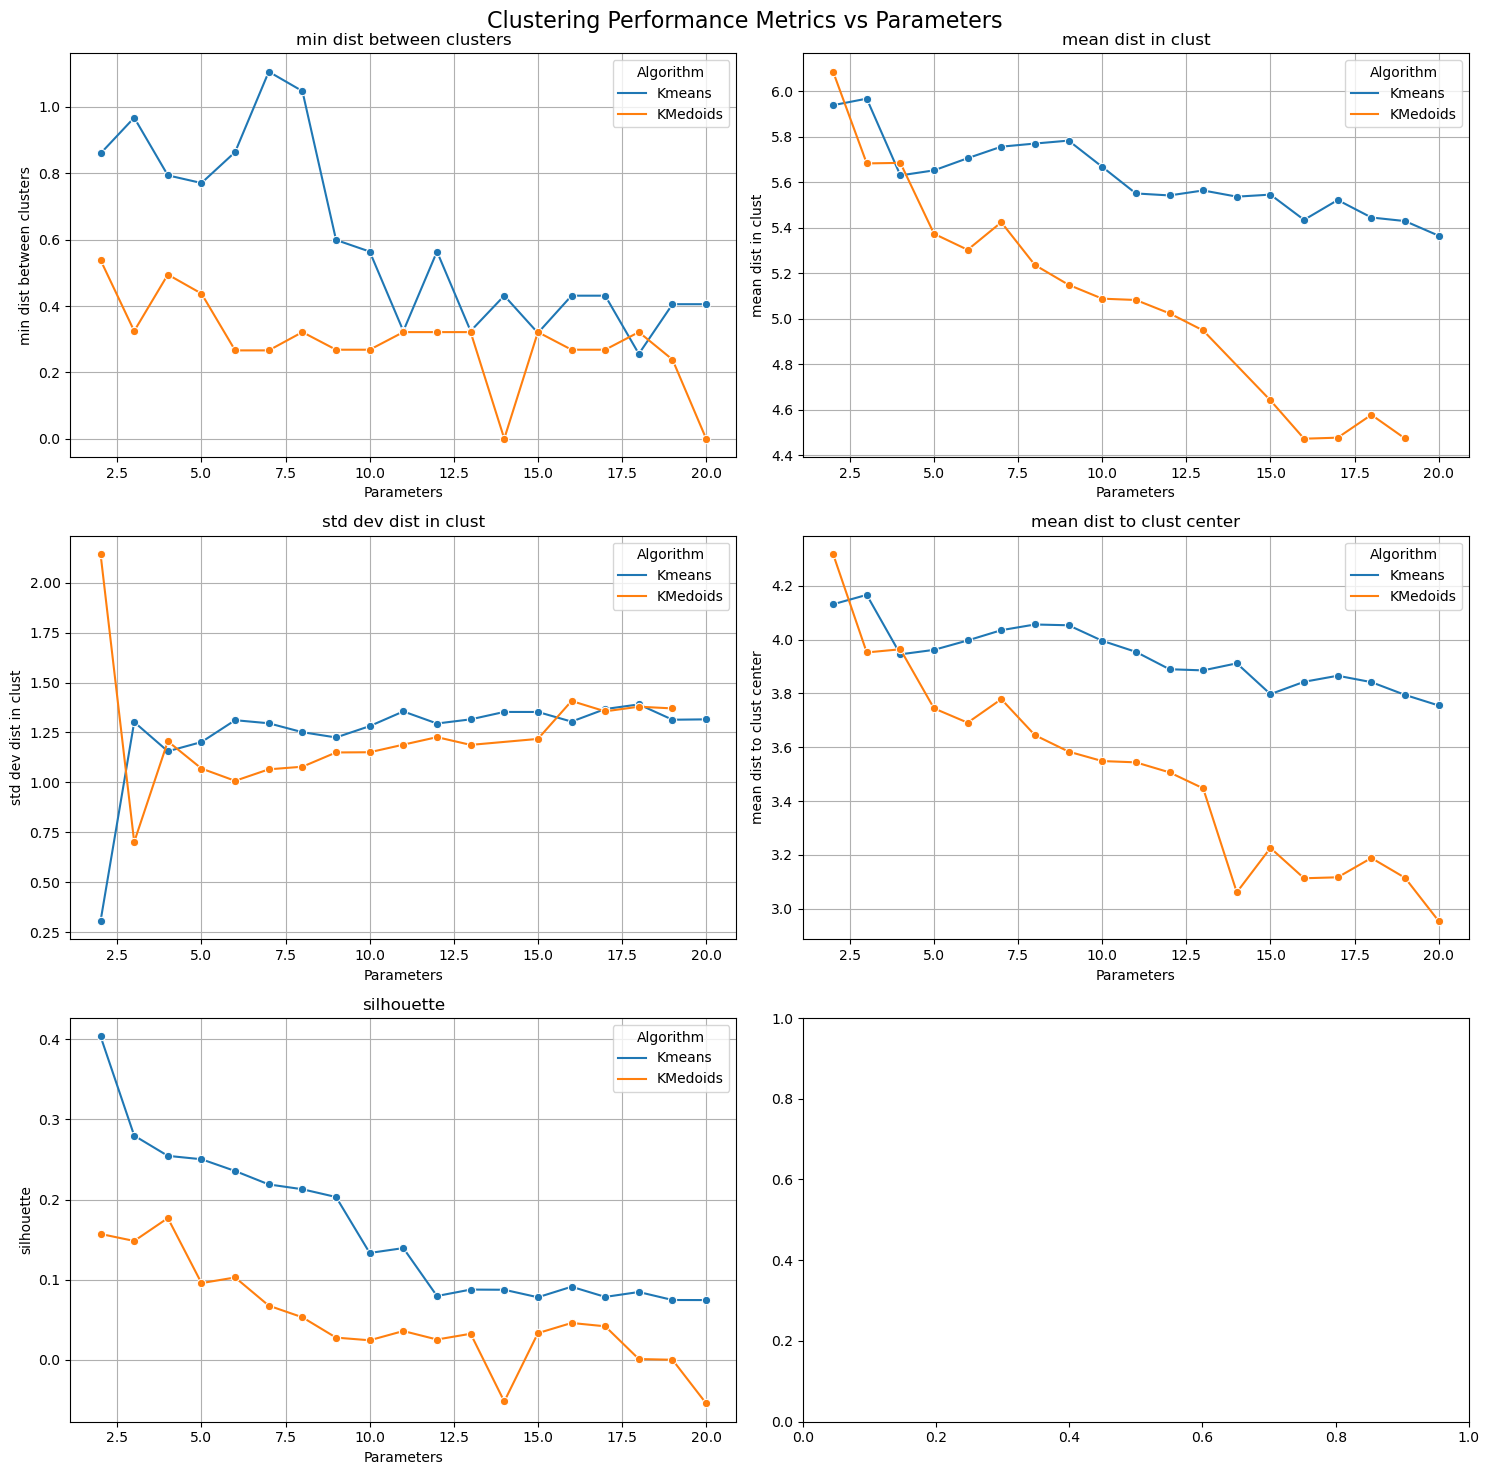

In [155]:
def plot_df(df):
    # List of metrics to plot
    metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette'
    ]

    # Set up the subplot grid (3 rows, 2 columns)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Iterate over metrics and create a plot for each
    for i, metric in enumerate(metrics_vals):
        sns.lineplot(data=df, x='Parameters', y=metric, hue='Algorithm', marker='o', ax=axes[i])
        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Parameters')
        axes[i].legend(title='Algorithm')
        axes[i].grid(True)
    fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
plot_df(df)

Shape of the images array: (9957, 32, 32, 3)


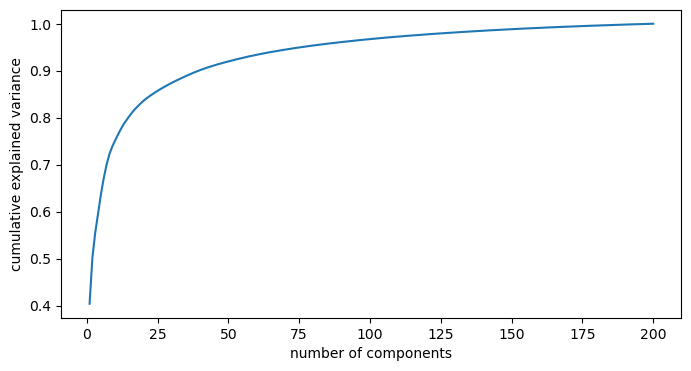

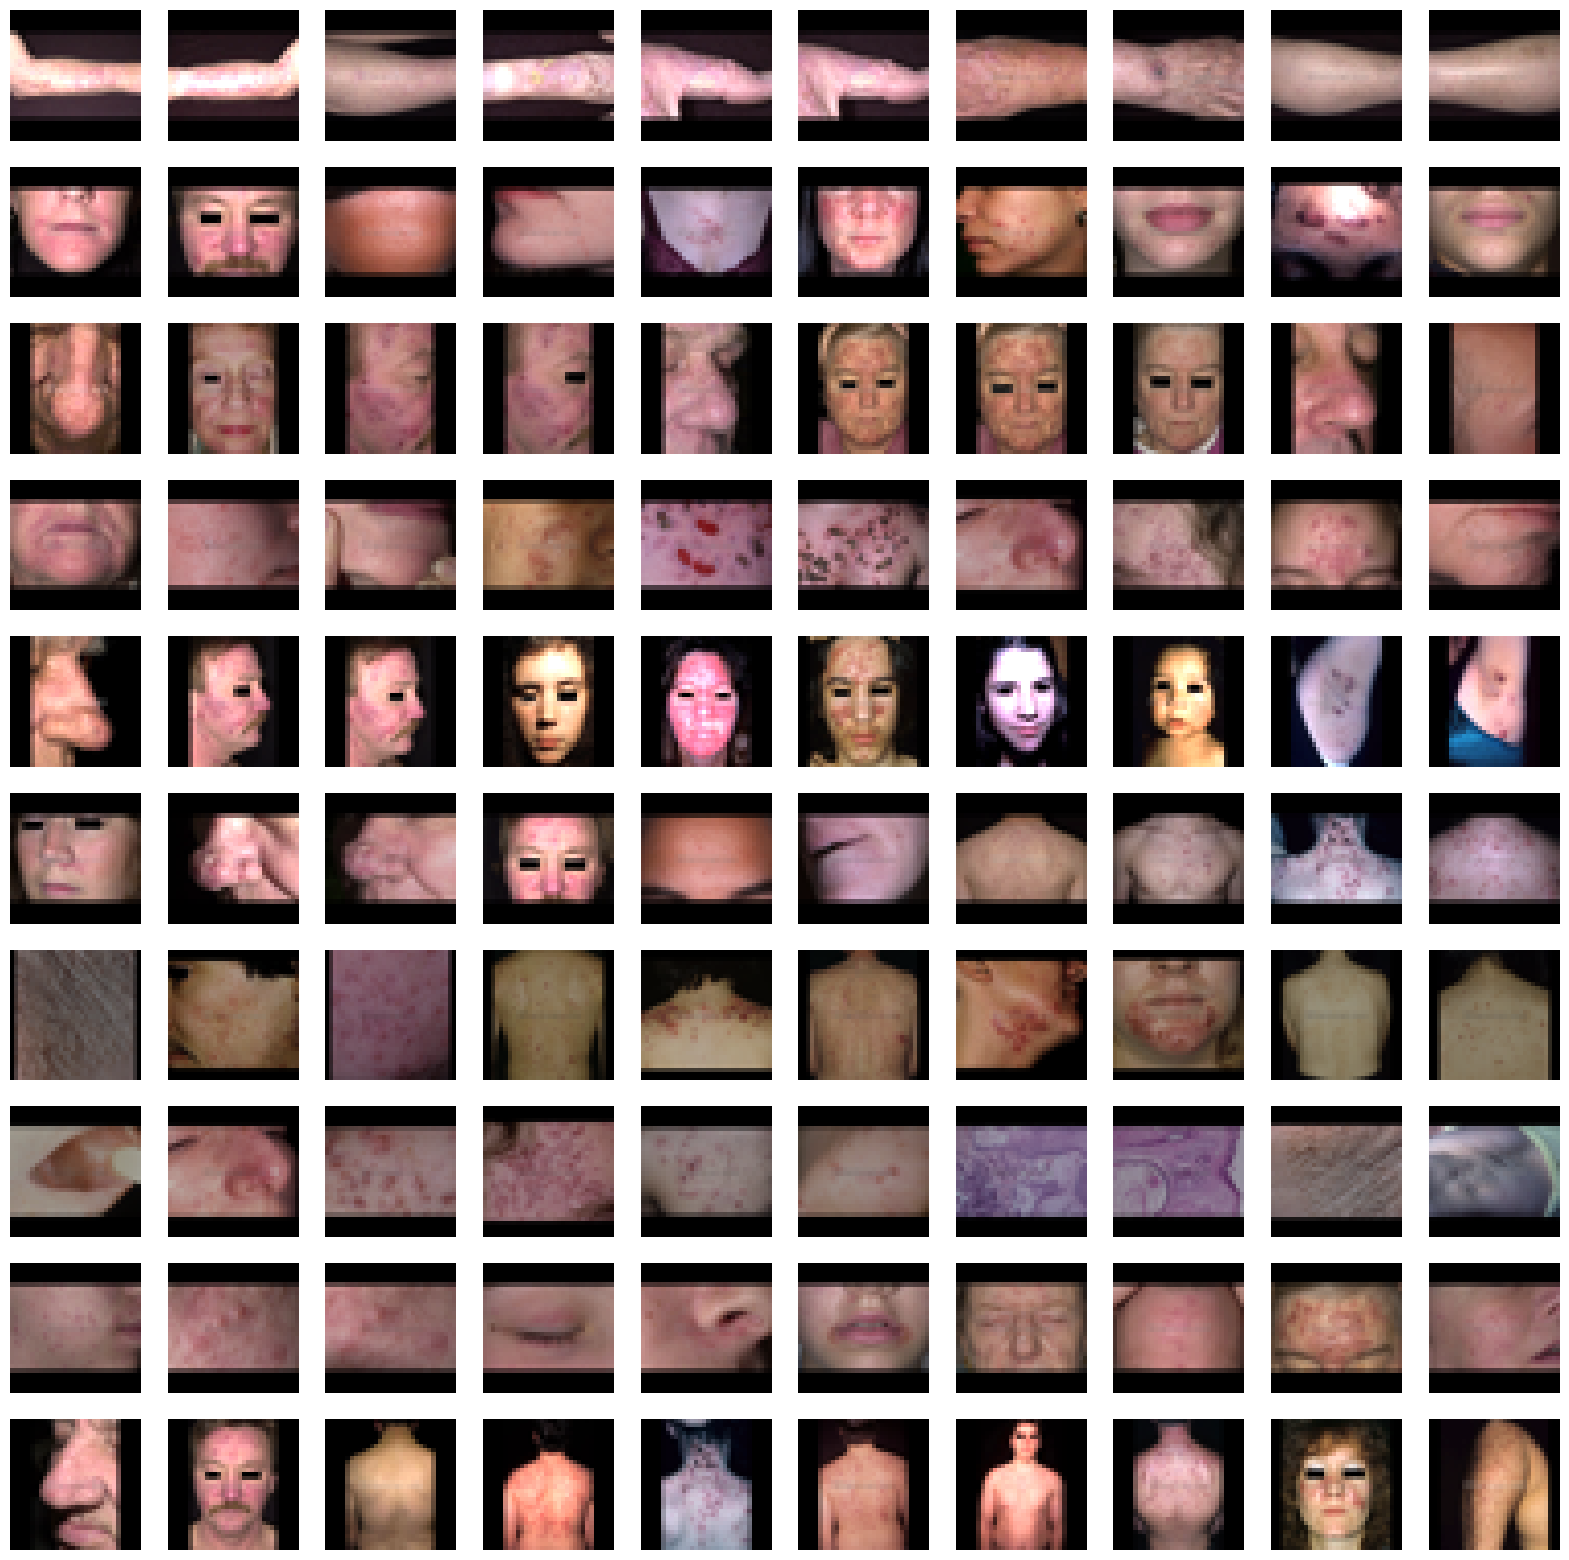

In [11]:
# Load images from directory and pad them to be square, then resize to 32x32
data_dir = '../Data/train'
img_size = 32
images = []
for root, dirs, files in os.walk(data_dir):
    for file in files[:500]:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img = add_padding_to_make_square(img)
            img = img.resize((img_size, img_size))
            images.append(img)

# Normalize the brightness of all images
normalized_images = normalize_images_brightness(images)

# Convert normalized images to numpy array
images_array = np.array([np.array(img) / 255.0 for img in normalized_images])

print(f"Shape of the images array: {images_array.shape}")

features = reduce_dimensions_pca(200, features, False)

clusters = KMeans(n_clusters=10, random_state=42).fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

## Conclusion
The best performing clustering algorithm for CNN is KMeans.

The number of clusters and the feature vector lengh that give the best results is indetermined.

It seems as if all metrics have better values with increasing number of features and clusters, but due to limited computational power only a part of passible parameters was checked.

Feature vector was ultimately reduced to a 200 dimansional one with PCA and the number of clusters giving the best metric results was determined to be >~10, although there is some overlap in some groups. With number of clusters >20 the overlap is smaller.